In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import theano
from pymc3 import model_to_graphviz
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


### Read in Data From Elections 1992-2016

In [2]:
df = pd.read_csv('data/capstone_sorteddata_featureengineered.csv')

In [3]:
df.head()

year       state  state_fips  rep_twoparty_voteshare  \
0  1992     Alabama           1                0.538211   
1  1992      Alaska           2                0.565743   
2  1992     Arizona           4                0.513019   
3  1992    Arkansas           5                0.400077   
4  1992  California           6                0.414833   

   dem_twoparty_voteshare  dem_state_win  rep_state_win  incumbent_present  \
0                0.461789              0              1                  0   
1                0.434257              0              1                  0   
2                0.486981              0              1                  0   
3                0.599923              1              0                  0   
4                0.585167              1              0                  0   

   incumbent_twoplus  Idx_Consumer_Sentiment  ...  pct_65to74  pct_75to84  \
0                  1                    75.0  ...         7.4         4.3   
1                  1                    75.0  ...         2.9         1.1   
2                  1                    75.0  ...         7.9         4.3   
3                  1                    75.0  ...         8.2         5.0   
4                  1                    75.0  ...         6.1         3.3   

   pct_85plus  pct_over65  pct_hispanic  pct_nonhispanic  pct_white_nh  \
0         1.3        13.0           0.6             99.4          72.9   
1         0.2         4.2           3.2             96.8          73.7   
2         1.1        13.3          20.1             79.9          70.2   
3         1.6        14.8           1.0             99.0          82.0   
4         1.0        10.4          27.2             72.8          55.2   

   pct_africanamerican  pct_asian  evangelical_pct  
0                 25.5        0.6         0.625551  
1                  4.0        3.7         0.270000  
2                  2.9        1.6         0.292388  
3                 16.0        0.5         0.592593  
4                  7.1        9.9         0.231393  

[5 rows x 71 columns]

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
df.tail(5)

year          state  state_fips  rep_twoparty_voteshare  \
352  2016       Virginia          51                0.471736   
353  2016     Washington          53                0.412131   
354  2016  West Virginia          54                0.721611   
355  2016      Wisconsin          55                0.504080   
356  2016        Wyoming          56                0.757053   

     dem_twoparty_voteshare  dem_state_win  rep_state_win  incumbent_present  \
352                0.528264              1              0                  0   
353                0.587869              1              0                  0   
354                0.278389              0              1                  0   
355                0.495920              0              1                  0   
356                0.242947              0              1                  0   

     incumbent_twoplus  Idx_Consumer_Sentiment  non_HSgraduate_vrate  \
352                  1                    89.4                  29.3   
353                  1                    89.4                  29.3   
354                  1                    89.4                  29.3   
355                  1                    89.4                  29.3   
356                  1                    89.4                  29.3   

     HS_graduate_vrate  some_college_vrate  bachelorplus_vrate  \
352               47.4                60.5                71.0   
353               47.4                60.5                71.0   
354               47.4                60.5                71.0   
355               47.4                60.5                71.0   
356               47.4                60.5                71.0   

     total_pop_vrate  white_pop_vrate  whitenonhispanic_vrate  \
352             56.0             58.2                    64.1   
353             56.0             58.2                    64.1   
354             56.0             58.2                    64.1   
355             56.0             58.2                    64.1   
356             56.0             58.2                    64.1   

     africanamerican_vrate  asian_vrate  hispanic_vrate  male_vrate  \
352                   55.9         33.9            32.5        53.8   
353                   55.9         33.9            32.5        53.8   
354                   55.9         33.9            32.5        53.8   
355                   55.9         33.9            32.5        53.8   
356                   55.9         33.9            32.5        53.8   

     female_vrate  Y1Q1_net_approval  Y1Q2A_net_approval  Y1Q3A_net_approval  \
352          58.1                 19                  15                   4   
353          58.1                 19                  15                   4   
354          58.1                 19                  15                   4   
355          58.1                 19                  15                   4   
356          58.1                 19                  15                   4   

     Y1Q4A_net_approval  Y2Q1A_net_approval  Y2Q2_net_approval  \
352                   0                   0                 -2   
353                   0                   0                 -2   
354                   0                   0                 -2   
355                   0                   0                 -2   
356                   0                   0                 -2   

     Y2Q3_net_approval  Y2Q4_net_approval  Y3Q1_net_approval  \
352                 -4                  2                  3   
353                 -4                  2                  3   
354                 -4                  2                  3   
355                 -4                  2                  3   
356                 -4                  2                  3   

     Y3Q2_net_approval  Y3Q3_net_approval  Y3Q4_net_approval  \
352                 -1                 -3                 -4   
353                 -1                 -3                 -4   
354                 -1              

In [6]:
cols = ['year', 'state_fips', 'dem_state_win', 'dem_margin', 'Pct_Over_National_Average', \
       'Idx_Consumer_Sentiment', 'urban_pct', 'pop_density', 'nonHS_graduate', 'pct_asian',\
       'advanced_degree_or_more', 'Y4_avg_net_approval', 'evangelical_pct', 'dem_voteshare_ratechange']

In [7]:
df_model = df[cols]

In [8]:
normalize_cols = ['evangelical_pct', 'Pct_Over_National_Average', 'Idx_Consumer_Sentiment', 'urban_pct', 'pop_density', 
                 'nonHS_graduate', 'pct_asian', 'advanced_degree_or_more', 'Y4_avg_net_approval', 'dem_margin', 
                 'dem_voteshare_ratechange']

In [9]:
df_model.Y4_avg_net_approval = df_model.Y4_avg_net_approval.astype('float')

In [10]:
df_model[normalize_cols] = df_model[normalize_cols].apply(lambda x: (x - np.mean(x)) / np.std(x))

In [11]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   year                       357 non-null    int64  
 1   state_fips                 357 non-null    int64  
 2   dem_state_win              357 non-null    int64  
 3   dem_margin                 357 non-null    float64
 4   Pct_Over_National_Average  357 non-null    float64
 5   Idx_Consumer_Sentiment     357 non-null    float64
 6   urban_pct                  357 non-null    float64
 7   pop_density                357 non-null    float64
 8   nonHS_graduate             357 non-null    float64
 9   pct_asian                  357 non-null    float64
 10  advanced_degree_or_more    357 non-null    float64
 11  Y4_avg_net_approval        357 non-null    float64
 12  evangelical_pct            357 non-null    float64
 13  dem_voteshare_ratechange   357 non-null    float64

In [12]:
df_model.head()

year  state_fips  dem_state_win  dem_margin  Pct_Over_National_Average  \
0  1992           1              0   -0.928793                  -0.850684   
1  1992           2              0   -1.161004                   0.150217   
2  1992           4              0   -1.024638                  -0.548512   
3  1992           5              1   -0.683503                  -1.381492   
4  1992           6              1   -0.166367                   0.861382   

   Idx_Consumer_Sentiment  urban_pct  pop_density  nonHS_graduate  pct_asian  \
0                -0.82213  -0.096429    -0.216221        2.676402  -0.434313   
1                -0.82213  -0.653059    -0.275624       -0.554388   0.048175   
2                -0.82213   0.972321    -0.250600        0.825247  -0.278672   
3                -0.82213  -1.086886    -0.242057        2.746257  -0.449877   
4                -0.82213   1.212562    -0.131321        1.314231   1.013150   

   advanced_degree_or_more  Y4_avg_net_approval  evangelical_pct  \
0                -1.052701            -0.759439         2.073954   
1                -0.386364            -0.759439        -0.511802   
2                -0.618133            -0.759439        -0.348987   
3                -1.371384            -0.759439         1.834266   
4                -0.299450            -0.759439        -0.792570   

   dem_voteshare_ratechange  
0                  0.008413  
1                  1.006891  
2                  0.910409  
3                  0.476208  
4                  0.918581

In [13]:
#save means and standard deviations to normalize the hold-out data
means = df[['Pct_Over_National_Average', 'Idx_Consumer_Sentiment', 'urban_pct', 'pop_density',
                 'nonHS_graduate', 'pct_asian', 'advanced_degree_or_more', 'Y4_avg_net_approval', 
            'dem_margin', 'dem_voteshare_ratechange', 'evangelical_pct']].mean()


stds = df[['Pct_Over_National_Average', 'Idx_Consumer_Sentiment', 'urban_pct', 'pop_density',
                 'nonHS_graduate', 'pct_asian', 'advanced_degree_or_more', 'Y4_avg_net_approval',
           'dem_margin', 'dem_voteshare_ratechange', 'evangelical_pct']].std()

In [14]:
num_states = len(df_model['state_fips'].unique())
states_lookup = dict(zip(df['state_fips'].unique() , range(len(df['state_fips'].unique()))))
states = df.state_fips.replace(states_lookup).values

This was the first model tried, but it did not converge that well and we opted for a non-centered model

In [15]:
with pm.Model() as election_model:
    
    # Priors
    mu_a = pm.Normal('mu_a', mu=0, sigma=5)
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    mu_b = pm.Normal('mu_b', mu=0, sigma=5)
    sigma_b = pm.HalfCauchy('sigma_b', 5)
    
    alpha = pm.Normal('alpha', mu_a, sd=sigma_a, shape=num_states)

    beta_income = pm.Normal('beta_income', mu_b, sd=sigma_b, shape=num_states)
    beta_consumer = pm.Normal('beta_consumer', mu_b, sd=sigma_b)
    beta_urban = pm.Normal('beta_urban', mu_b, sd=sigma_b, shape=num_states)
    beta_density = pm.Normal('beta_density', mu_b, sd=sigma_b, shape=num_states)
    beta_nonHS = pm.Normal('beta_nonHS', mu_b, sd=sigma_b, shape=num_states)
    beta_pctasian = pm.Normal('beta_pctasian', mu_b, sd=sigma_b, shape=num_states)
    beta_advanced = pm.Normal('beta_advanced', mu_b, sd=sigma_b, shape=num_states)
    beta_approval = pm.Normal('beta_approval', mu_b, sd=sigma_b)
    beta_evan = pm.Normal('beta_evan', mu_b, sd=sigma_b, shape=num_states)
    
   
    income = pm.Data('income', df.Pct_Over_National_Average.values)
    consumer = pm.Data('consumer', df.Idx_Consumer_Sentiment.values)
    urban = pm.Data('urban', df.urban_pct.values)
    density = pm.Data('density', df.pop_density.values)
    nonHS = pm.Data('nonHS', df.nonHS_graduate.values)
    pct_asian = pm.Data('pct_asian', df.pct_asian.values)
    adv_degree = pm.Data('adv_degree', df.advanced_degree_or_more.values)
    approval = pm.Data('approval', df.Y4_avg_net_approval.values)
    evang = pm.Data('evang', df.evangelical_pct.values)
    
    states = pm.Data('states', states)
    
    dem_win = pm.Data('dem_win', df.dem_state_win.values)
    
    sigma_y = pm.HalfCauchy('sigma_y',0.001)
    
    mu = alpha[states] + beta_income[states] * income  + beta_consumer * consumer + beta_urban[states] * urban + beta_density[states] * density  + beta_nonHS[states] * nonHS + beta_pctasian[states] * pct_asian + beta_advanced[states] * adv_degree + beta_approval * approval + beta_evan[states] * evang + sigma_y
    
    
    
    #theta = pm.Deterministic('theta', pm.invlogit(mu))
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    
    #Y_obs = pm.Binomial('Y_obs', p=theta, n=num_states, observed=df['dem_state_win'].values)
    
    Y_obs = pm.Bernoulli('Y_obs', theta, observed=dem_win)
    
#model_to_graphviz(election_model)

The following is the model using all of our relevant predictors

In [15]:
with pm.Model() as election_model_full:
    
    # Priors
    mu_a = pm.Normal('mu_a', mu=0, sigma=5)
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    mu_b = pm.Normal('mu_b', mu=0, sigma=5)
    sigma_b = pm.HalfCauchy('sigma_b', 5)
    
    alpha_offset = pm.Normal('alpha_offset', mu=0, sd=1, shape=num_states)
    alpha = pm.Deterministic('alpha', mu_a + alpha_offset * sigma_a)
    
    beta_i_offset = pm.Normal('beta_i_offset', mu=0, sd=1, shape=num_states)
    beta_income = pm.Deterministic('beta_income', mu_b + beta_i_offset * sigma_b)
    beta_demmargin_offset = pm.Normal('beta_demmargin_offset', 0, 1, shape=num_states)
    beta_demmargin = pm.Deterministic('beta_demmargin', mu_b + beta_demmargin_offset * sigma_b)
    beta_urban_offset = pm.Normal('beta_urban_offset', 0, 1, shape=num_states)
    beta_urban = pm.Deterministic('beta_urban', mu_b + beta_urban_offset * sigma_b)
    beta_dens_offset = pm.Normal('beta_dens_offset', 0, 1, shape=num_states)
    beta_density = pm.Deterministic('beta_density', mu_b + sigma_b * beta_dens_offset)
    beta_nonHS_offset = pm.Normal('beta_nonHS_offset', 0, 1, shape=num_states)
    beta_nonHS = pm.Deterministic('beta_nonHS', mu_b + sigma_b * beta_nonHS_offset)
    beta_pctasian_offset = pm.Normal('beta_pctasian_offset', 0, 1, shape=num_states)
    beta_pctasian = pm.Deterministic('beta_pctasian', mu_b + sigma_b * beta_pctasian_offset)
    beta_adv_offset = pm.Normal('beta_adv_offset', 0, 1, shape=num_states)
    beta_advanced = pm.Deterministic('beta_advanced', mu_b + sigma_b * beta_adv_offset)
    beta_demshare_offset = pm.Normal('beta_demshare_offset', 0, 1, shape=num_states)
    beta_demshare = pm.Deterministic('beta_demshare', mu_b + sigma_b * beta_demshare_offset)
    beta_evan_offset = pm.Normal('beta_evan_offset', 0, 1, shape=num_states)
    beta_evan = pm.Deterministic('beta_evan', mu_b + sigma_b * beta_evan_offset)
    beta_consumer_offset = pm.Normal('beta_consumer_offset', 0, 1)
    beta_consumer = pm.Deterministic('beta_consumer', mu_b + sigma_b * beta_consumer_offset)
    beta_approval_offset = pm.Normal('beta_approval_offset', 0, 1)
    beta_approval = pm.Deterministic('beta_approval', mu_b + sigma_b * beta_approval_offset)
   
    income = pm.Data('income', df_model.Pct_Over_National_Average.values)
    demmargin = pm.Data('demmargin', df_model.dem_margin.values)
    urban = pm.Data('urban', df_model.urban_pct.values)
    density = pm.Data('density', df_model.pop_density.values)
    nonHS = pm.Data('nonHS', df_model.nonHS_graduate.values)
    pct_asian = pm.Data('pct_asian', df_model.pct_asian.values)
    adv_degree = pm.Data('adv_degree', df_model.advanced_degree_or_more.values)
    dem_voteshare = pm.Data('dem_voteshare', df_model.dem_voteshare_ratechange.values)
    evang = pm.Data('evang', df_model.evangelical_pct.values)
    consumer = pm.Data('consumer', df_model.Idx_Consumer_Sentiment.values)
    approval = pm.Data('approval', df_model.Y4_avg_net_approval.values)
    
    states = pm.Data('states', states)
    
    dem_win = pm.Data('dem_win', df_model.dem_state_win.values)
    
    sigma_y = pm.HalfCauchy('sigma_y',0.001)
    
    
    mu = alpha[states] + beta_income[states] * income  + beta_demmargin[states] * demmargin + beta_urban[states] * urban + beta_density[states] * density + beta_nonHS[states] * nonHS + beta_pctasian[states] * pct_asian + beta_advanced[states] * adv_degree + beta_demshare[states] * dem_voteshare + beta_evan[states] * evang + beta_consumer * consumer + beta_approval * approval + sigma_y
    
    
    
    #theta = pm.Deterministic('theta', pm.invlogit(mu))
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    
    
    Y_obs = pm.Bernoulli('Y_obs', theta, observed=dem_win)

In [52]:
# with election_model2:
#      trace = pm.sample(8000, chains=4, tune=2000, target_accept=0.95)

#nuts_kwargs=dict(target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sigma_y, beta_consumer_offset, beta_evan_offset, beta_demshare_offset, beta_adv_offset, beta_pctasian_offset, beta_dens_offset, beta_urban_offset, beta_demmargin_offset, beta_i_offset, alpha_offset, sigma_b, mu_b, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 8_000 draw iterations (8_000 + 32_000 draws total) took 1975 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [53]:
#pm.save_trace(trace, 'models/model1_trace.trace', overwrite=True)

'models/model1_trace.trace'

In [16]:
trace_full = pm.load_trace('models/model1_trace.trace', election_model_full)

In [54]:
pm.summary(trace_full)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
mu_a             0.762  2.123  -3.333    5.088      0.020    0.017   11758.0   
mu_b             3.860  2.215   0.956    8.044      0.038    0.027    3446.0   
alpha_offset[0] -0.384  0.954  -2.202    1.387      0.006    0.005   23100.0   
alpha_offset[1] -0.632  0.895  -2.306    1.050      0.007    0.005   14432.0   
alpha_offset[2] -0.243  0.822  -1.790    1.323      0.005    0.005   24951.0   
...                ...    ...     ...      ...        ...      ...       ...   
theta[352]       0.937  0.153   0.645    1.000      0.001    0.001   18001.0   
theta[353]       0.996  0.034   0.997    1.000      0.000    0.000   30661.0   
theta[354]       0.000  0.006   0.000    0.000      0.000    0.000   22997.0   
theta[355]       0.378  0.338   0.000    0.946      0.004    0.003    7614.0   
theta[356]       0.002  0.022   0.000    0.000      0.000    0.000   30451.0   

                  ess_sd  ess_bulk  ess_tail  r_hat  
mu_a              8259.0   12938.0   11737.0    1.0  
mu_b              3446.0    3202.0    8007.0    1.0  
alpha_offset[0]  16778.0   23092.0   22084.0    1.0  
alpha_offset[1]  14432.0   14567.0   16782.0    1.0  
alpha_offset[2]  15698.0   25184.0   20389.0    1.0  
...                  ...       ...       ...    ...  
theta[352]       15886.0    7292.0   27198.0    1.0  
theta[353]       30536.0    6889.0   23825.0    1.0  
theta[354]       22997.0    3411.0    9820.0    1.0  
theta[355]        7614.0    6988.0   13379.0    1.0  
theta[356]       30451.0    5008.0   12924.0    1.0  

[1282 rows x 11 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5fcebebd60>,
      dtype=object)

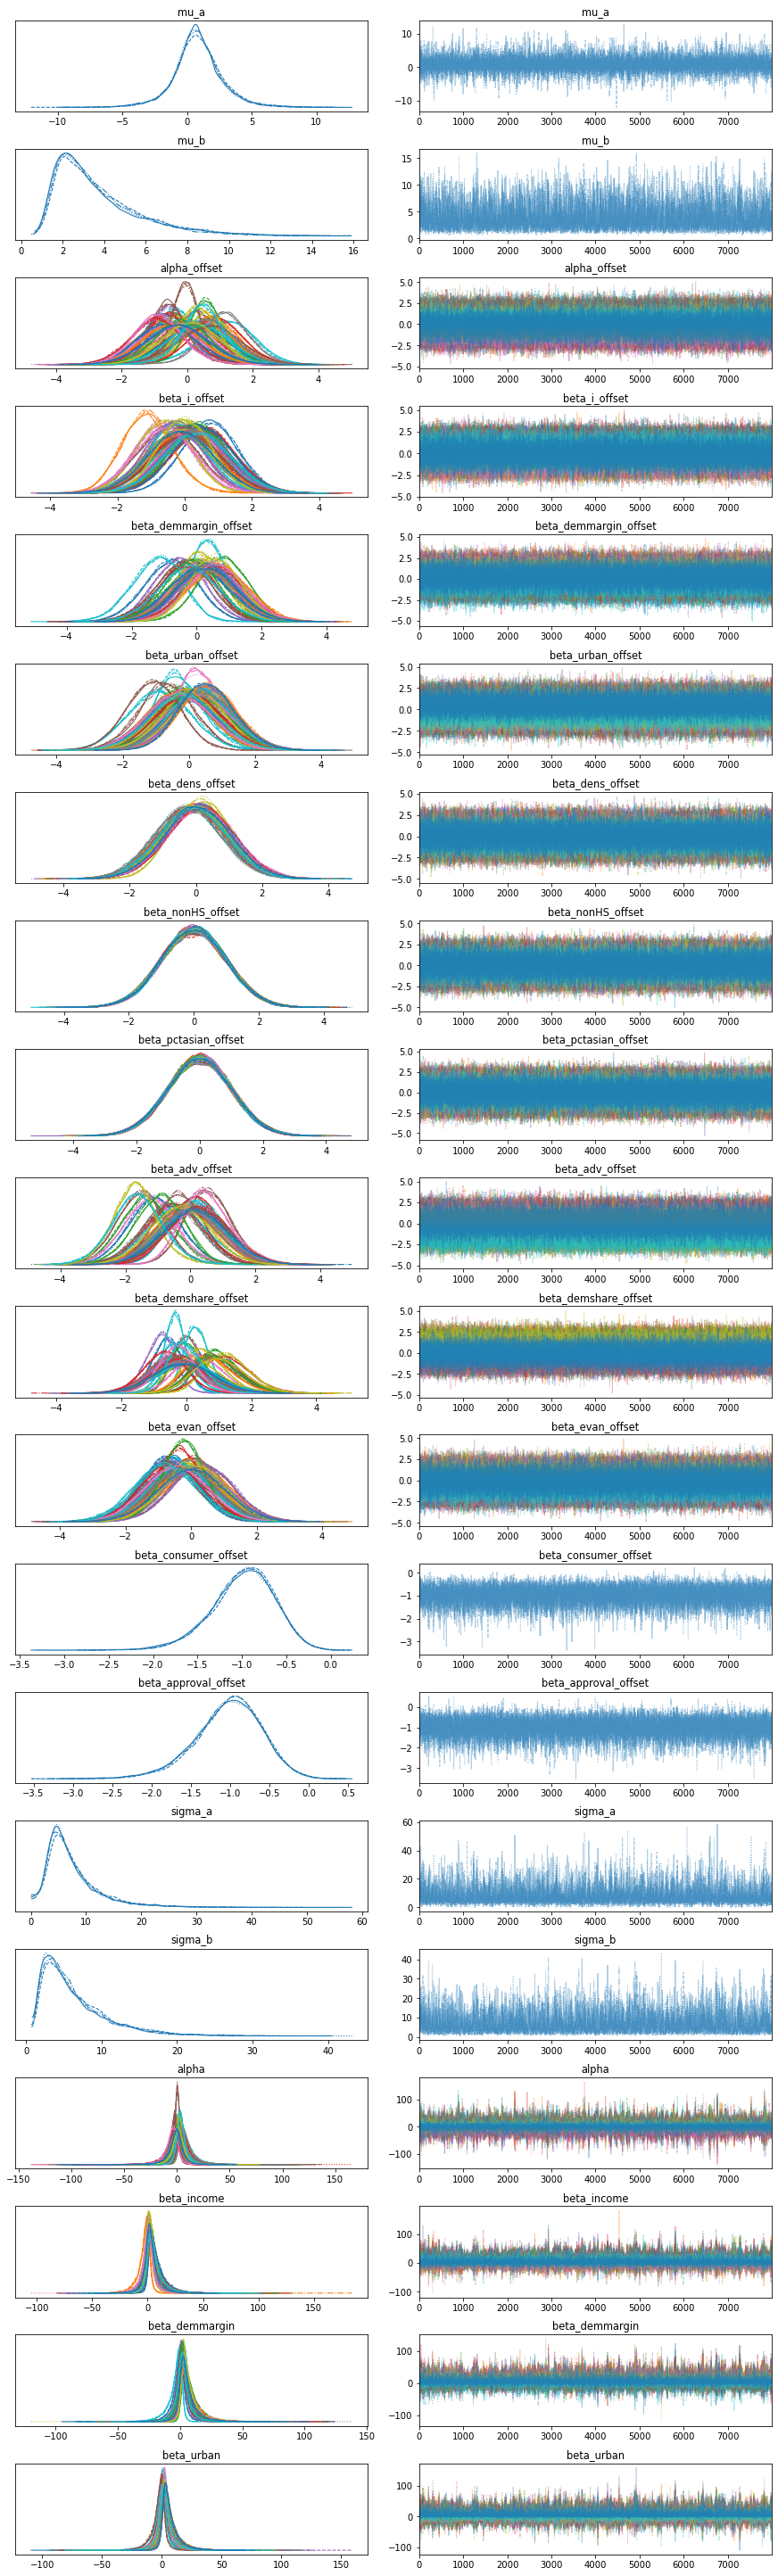

In [20]:
pm.traceplot(trace_full)

#### 2020 Data

In [15]:
df20 = pd.read_csv('data/2020data_featureengineered.csv')

In [16]:
df20 = df20.rename(columns={'adv or more': 'advanced_degree_or_more', 'Y4_avg_qtr_net_approval': 'Y4_avg_net_approval'})

In [17]:
df20 = df20.drop(columns = 'Unemp_Rate')

In [18]:
df20.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year                       51 non-null     int64  
 1   State                      51 non-null     object 
 2   Y4_avg_net_approval        51 non-null     int64  
 3   Pct_Over_National_Average  51 non-null     float64
 4   Idx_Consumer_Sentiment     51 non-null     float64
 5   pop_density                51 non-null     float64
 6   urban_pct                  51 non-null     float64
 7   nonHS_graduate             51 non-null     float64
 8   pct_asian                  51 non-null     float64
 9   evangelical_pct            51 non-null     float64
 10  advanced_degree_or_more    51 non-null     float64
 11  dem_voteshare_ratechange   51 non-null     float64
 12  dem_margin                 51 non-null     float64
dtypes: float64(10), int64(2), object(1)
memory usage: 5.

In [19]:
df20.head()

Year       State  Y4_avg_net_approval  Pct_Over_National_Average  \
0  2020     Alabama                   -7                  -0.272383   
1  2020      Alaska                   -7                   0.091483   
2  2020     Arizona                   -7                  -0.226190   
3  2020    Arkansas                   -7                  -0.267008   
4  2020  California                   -7                   0.154080   

   Idx_Consumer_Sentiment  pop_density  urban_pct  nonHS_graduate  pct_asian  \
0                    74.1         95.4     0.7684            12.9        1.3   
1                    74.1          1.3     0.6741             6.5        5.9   
2                    74.1         58.3     0.9515            12.4        3.2   
3                    74.1         56.9     0.6272            12.5        1.5   
4                    74.1        246.1     0.9788            16.0       14.6   

   evangelical_pct  advanced_degree_or_more  dem_voteshare_ratechange  \
0         0.645793                     10.0                 -3.157915   
1         0.290323                     11.7                 -1.070364   
2         0.327718                     11.3                  2.723357   
3         0.559486                      8.3                 -2.130732   
4         0.267244                     13.1                  4.255409   

   dem_margin  
0  -28.748287  
1  -16.771309  
2   -3.780047  
3  -28.570275  
4   32.256441

In [20]:
df20 = df20[['Pct_Over_National_Average', 'Idx_Consumer_Sentiment', 'urban_pct', 'pop_density', 'nonHS_graduate',
            'pct_asian', 'advanced_degree_or_more', 'Y4_avg_net_approval', 'evangelical_pct', 'dem_margin', 
            'dem_voteshare_ratechange']]

In [21]:
stds

Pct_Over_National_Average      15.127957
Idx_Consumer_Sentiment         13.485655
urban_pct                       0.186741
pop_density                  1355.029301
nonHS_graduate                  5.734191
pct_asian                       6.434053
advanced_degree_or_more         3.456551
Y4_avg_net_approval            18.008450
dem_margin                     20.852919
dem_voteshare_ratechange        5.390516
evangelical_pct                 0.137697
dtype: float64

In [22]:
df20 = (df20 - means) / stds

In [23]:
df20.head()

Idx_Consumer_Sentiment  Pct_Over_National_Average  Y4_avg_net_approval  \
0               -0.887716                   0.132001            -0.389658   
1               -0.887716                   0.156054            -0.389658   
2               -0.887716                   0.135055            -0.389658   
3               -0.887716                   0.132356            -0.389658   
4               -0.887716                   0.160191            -0.389658   

   advanced_degree_or_more  dem_margin  dem_voteshare_ratechange  \
0                 0.163859   -1.371417                 -0.859000   
1                 0.655679   -0.797062                 -0.471736   
2                 0.539956   -0.174067                  0.232041   
3                -0.327961   -1.362881                 -0.668446   
4                 1.060707    1.554060                  0.516253   

   evangelical_pct  nonHS_graduate  pct_asian  pop_density  urban_pct  
0         2.218051       -0.571050  -0.324908    -0.205586   0.098093  
1        -0.363495       -1.687162   0.390038    -0.275031  -0.406884  
2        -0.091915       -0.658246  -0.029604    -0.232965   1.078594  
3         1.591260       -0.640807  -0.293824    -0.233999  -0.658034  
4        -0.531101       -0.030433   1.742218    -0.094371   1.224785

In [24]:
states50 = np.arange(51, step=1, dtype='int32') #need to update the states data 

In [30]:
states50.dtype

dtype('int32')

In [27]:
with election_model_full:
    pm.set_data({'states': states50, 'income': df20.Pct_Over_National_Average.values, 'consumer': df20.Idx_Consumer_Sentiment.values,
               'urban': df20.urban_pct.values, 'density': df20.pop_density.values, 'pct_asian': df20.pct_asian.values, 'nonHS': df20.nonHS_graduate.values,
               'evang': df20.evangelical_pct.values, 'demmargin': df20.dem_margin.values, 'dem_voteshare': df20.dem_voteshare_ratechange.values,
                'approval': df20.Y4_avg_net_approval.values, 'adv_degree': df20.advanced_degree_or_more.values})
                #'dem_win': np.empty_like(df20.evangelical_pct.values)})
    y_test = pm.sample_posterior_predictive(trace_full, var_names = ['theta'])


In [28]:
results = pd.DataFrame.from_records(y_test['theta'])

In [29]:
results

0             1         2             3         4         5  \
0      2.704460e-10  3.479662e-10  0.000585  9.976976e-01  1.000000  0.000251   
1      8.713951e-01  2.189911e-11  0.997094  9.267693e-14  1.000000  0.913496   
2      1.519235e-04  1.859144e-06  0.998191  9.286465e-01  0.998991  0.998443   
3      1.765041e-08  5.618723e-07  0.020287  2.498251e-02  1.000000  0.998874   
4      6.609733e-06  8.444824e-04  0.147743  6.395970e-02  1.000000  0.999932   
...             ...           ...       ...           ...       ...       ...   
31995  2.797662e-03  4.037697e-10  0.407468  7.452522e-01  1.000000  0.078622   
31996  2.982754e-02  1.667831e-02  0.917929  5.499444e-01  0.999999  0.533139   
31997  2.050668e-05  2.779246e-11  0.999998  4.403931e-02  1.000000  0.991877   
31998  1.961959e-06  7.180106e-04  0.000038  7.438417e-02  1.000000  0.000219   
31999  7.742278e-03  5.626590e-10  1.000000  9.747656e-01  1.000000  0.994482   

              6         7         8         9            10        11  \
0      0.999897  1.000000  1.000000  0.003867  3.267927e-06  1.000000   
1      1.000000  0.999999  0.999969  0.999981  1.211073e-04  1.000000   
2      0.071866  0.131914  1.000000  0.999572  3.201528e-09  0.998494   
3      0.999998  0.004506  1.000000  0.450703  3.609284e-15  0.860308   
4      0.000467  0.000027  1.000000  0.042243  1.379061e-07  1.000000   
...         ...       ...       ...       ...           ...       ...   
31995  1.000000  0.961892  1.000000  0.407039  4.267317e-01  1.000000   
31996  0.999893  0.999969  1.000000  0.006384  8.185713e-03  0.999229   
31997  0.999996  0.999989  1.000000  0.001649  9.680071e-01  1.000000   
31998  0.853424  0.946411  1.000000  0.977516  4.379660e-04  1.000000   
31999  0.980193  1.000000  1.000000  0.312273  4.333018e-01  1.000000   

                 12        13            14            15            16  \
0      1.320307e-27  1.000000  8.756271e-01  1.073037e-10  6.197244e-10   
1      1.692878e-12  1.000000  2.917326e-01  4.357156e-10  2.779606e-01   
2      9.959705e-01  0.998499  1.533859e-02  5.753713e-03  9.965584e-01   
3      7.402536e-06  0.999963  4.783420e-07  1.466337e-12  2.177410e-01   
4      2.680039e-05  1.000000  2.246216e-02  1.436918e-12  6.720617e-05   
...             ...       ...           ...           ...           ...   
31995  6.270678e-05  0.994881  9.616819e-02  1.869304e-04  1.657836e-02   
31996  1.523497e-03  1.000000  5.789499e-02  8.339845e-02  2.382703e-04   
31997  7.916075e-01  0.990134  1.633912e-01  3.320744e-02  5.455419e-05   
31998  6.859895e-05  0.999999  7.239454e-01  3.888349e-09  7.461156e-03   
31999  7.897896e-01  1.000000  3.535551e-01  4.417481e-06  1.981672e-08   

                 17        18        19        20        21        22  \
0      9.990344e-01  0.790001  1.000000  1.000000  1.000000  0.282151   
1      6.398051e-04  0.747923  1.000000  1.000000  0.999981  1.000000   
2      1.438193e-07  0.992131  0.010891  0.925241  1.000000  0.070033   
3      5.819430e-11  0.000923  0.999862  0.078239  0.999998  0.000030   
4      6.735176e-01  0.000022  0.000568  1.000000  1.000000  0.711627   
...             ...       ...       ...       ...       ...       ...   
31995  2.535158e-04  0.775010  0.999999  1.000000  1.000000  0.006651   
31996  4.503007e-03  0.034169  0.439102  0.999832  0.999999  0.996344   
31997  1.611099e-07  0.041181  0.969196  0.992044  1.000000  0.035145   
31998  9.802952e-03  0.223757  1.000000  0.999995  1.000000  0.740068   
31999  3.127338e-09  0.008265  1.000000  1.000000  1.000000  0.762615   

             23            24            25            26            27  \
0      1.000000  2.671381e-03  2.305542e-06  2.496097e-16  1.770135e-09   
1      0.999540  8.984186e-13  2.724596e-11  5.167661e-12  1.267018e-06   
2      0.999389  1.403851e-07  2.002650e-05  1.239979e-18  9.861596e-03   
3      0.999999  2.892353e-18  2.783866e-13  3.859337e-26  2.924312e-13   
4      0.990121

In [30]:
res = results.apply('mean')

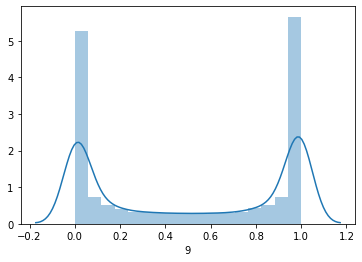

In [31]:
sns.distplot(results[9])

In [32]:
percentiles = results.apply(lambda x: np.percentile(x,q=[97.5, 2.5]))

In [33]:
percentiles

0             1             2             3         4  \
0  9.999992e-01  9.999977e-01  1.000000e+00  1.000000e+00  1.000000   
1  6.777929e-37  1.618609e-34  1.422858e-10  1.673710e-20  0.994763   

              5             6         7         8             9            10  \
0  1.000000e+00  1.000000e+00  1.000000  1.000000  1.000000e+00  9.999997e-01   
1  1.227144e-09  5.821827e-10  0.000155  0.024385  1.828644e-09  8.766378e-22   

         11            12        13            14            15            16  \
0  1.000000  9.999892e-01  1.000000  1.000000e+00  9.977550e-01  9.998102e-01   
1  0.034144  1.440746e-39  0.004016  6.660696e-13  1.034724e-36  3.988152e-32   

             17            18            19        20        21            22  \
0  9.994883e-01  9.990431e-01  1.000000e+00  1.000000  1.000000  1.000000e+00   
1  1.221606e-32  1.948997e-19  3.703579e-11  0.000616  0.000032  2.056094e-18   

             23            24            25            26            27  \
0  1.000000e+00  1.000000e+00  8.830305e-01  6.897123e-01  9.998874e-01   
1  8.670800e-14  2.124105e-39  7.652633e-38  3.138506e-55  1.247577e-35   

         28            29            30            31       32            33  \
0  1.000000  1.000000e+00  1.000000e+00  1.000000e+00  1.00000  1.000000e+00   
1  0.001961  1.152864e-11  2.910832e-07  2.784450e-09  0.00263  2.754530e-08   

             34            35            36        37            38        39  \
0  9.997981e-01  9.999923e-01  8.800156e-01  1.000000  9.999987e-01  1.000000   
1  9.488590e-59  3.740605e-27  1.311353e-40  0.000017  2.470759e-21  0.000003   

             40            41            42            43            44  \
0  1.000000e+00  9.735832e-01  9.999948e-01  9.999767e-01  1.000000e+00   
1  6.905725e-23  9.603744e-52  3.675403e-23  3.605057e-14  1.046324e-39   

         45        46        47            48            49            50  
0  1.000000  1.000000  1.000000  1.684637e-01  1.000000e+00  5.177881e-01  
1  0.003682  0.000035  0.000017  1.244593e-55  1.619602e-19  1.274506e-71

In [35]:
states = df['state'][:51].tolist()

In [35]:
res_states = res.to_frame()

In [36]:
res_states['States'] = states

In [37]:
res_states

0                States
0   0.146968               Alabama
1   0.109151                Alaska
2   0.610263               Arizona
3   0.314443              Arkansas
4   0.992746            California
5   0.705225              Colorado
6   0.829968           Connecticut
7   0.894506              Delaware
8   0.966498  District of Columbia
9   0.510857               Florida
10  0.278090               Georgia
11  0.958655                Hawaii
12  0.101741                 Idaho
13  0.933167              Illinois
14  0.429582               Indiana
15  0.079838                  Iowa
16  0.092617                Kansas
17  0.100595              Kentucky
18  0.161961             Louisiana
19  0.756732                 Maine
20  0.935171              Maryland
21  0.928699         Massachusetts
22  0.391257              Michigan
23  0.709185             Minnesota
24  0.160109           Mississippi
25  0.041017              Missouri
26  0.030322               Montana
27  0.087644              Nebraska
28  0.849117                Nevada
29  0.694530         New Hampshire
30  0.882107            New Jersey
31  0.711802            New Mexico
32  0.938602              New York
33  0.612564        North Carolina
34  0.062779          North Dakota
35  0.154279                  Ohio
36  0.042927              Oklahoma
37  0.899024                Oregon
38  0.248978          Pennsylvania
39  0.858826          Rhode Island
40  0.291139        South Carolina
41  0.043519          South Dakota
42  0.194516             Tennessee
43  0.271833                 Texas
44  0.243961                  Utah
45  0.939227               Vermont
46  0.837684              Virginia
47  0.905053            Washington
48  0.018463         West Virginia
49  0.371263             Wisconsin
50  0.026006               Wyoming

In [66]:
res_states.to_csv('state_probs.csv', index=False)

### Try Different Models and Compare

In [17]:
states = df.state_fips.replace(states_lookup).values

with pm.Model() as election_model2:
    
    # Priors
    mu_a = pm.Normal('mu_a', mu=0, sigma=5)
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    mu_b = pm.Normal('mu_b', mu=0, sigma=5)
    sigma_b = pm.HalfCauchy('sigma_b', 5)
    
    alpha_offset = pm.Normal('alpha_offset', mu=0, sd=1, shape=num_states)
    alpha = pm.Deterministic('alpha', mu_a + alpha_offset * sigma_a)
    
    beta_i_offset = pm.Normal('beta_i_offset', mu=0, sd=1, shape=num_states)
    beta_income = pm.Deterministic('beta_income', mu_b + beta_i_offset * sigma_b)
    beta_demmargin_offset = pm.Normal('beta_demmargin_offset', 0, 1, shape=num_states)
    beta_demmargin = pm.Deterministic('beta_demmargin', mu_b + beta_demmargin_offset * sigma_b)
    beta_urban_offset = pm.Normal('beta_urban_offset', 0, 1, shape=num_states)
    beta_urban = pm.Deterministic('beta_urban', mu_b + beta_urban_offset * sigma_b)
    beta_dens_offset = pm.Normal('beta_dens_offset', 0, 1, shape=num_states)
    beta_density = pm.Deterministic('beta_density', mu_b + sigma_b * beta_dens_offset)
    #beta_nonHS_offset = pm.Normal('beta_nonHS_offset', 0, 1, shape=num_states)
    #beta_nonHS = pm.Deterministic('beta_nonHS', mu_b + sigma_b * beta_nonHS_offset)
    beta_pctasian_offset = pm.Normal('beta_pctasian_offset', 0, 1, shape=num_states)
    beta_pctasian = pm.Deterministic('beta_pctasian', mu_b + sigma_b * beta_pctasian_offset)
    beta_adv_offset = pm.Normal('beta_adv_offset', 0, 1, shape=num_states)
    beta_advanced = pm.Deterministic('beta_advanced', mu_b + sigma_b * beta_adv_offset)
    beta_demshare_offset = pm.Normal('beta_demshare_offset', 0, 1, shape=num_states)
    beta_demshare = pm.Deterministic('beta_demshare', mu_b + sigma_b * beta_demshare_offset)
    beta_evan_offset = pm.Normal('beta_evan_offset', 0, 1, shape=num_states)
    beta_evan = pm.Deterministic('beta_evan', mu_b + sigma_b * beta_evan_offset)
    beta_consumer_offset = pm.Normal('beta_consumer_offset', 0, 1)
    beta_consumer = pm.Deterministic('beta_consumer', mu_b + sigma_b * beta_consumer_offset)
    #beta_approval_offset = pm.Normal('beta_approval_offset', 0, 1)
    #beta_approval = pm.Deterministic('beta_approval', mu_b + sigma_b * beta_approval_offset)
   
    income = pm.Data('income', df_model.Pct_Over_National_Average.values)
    demmargin = pm.Data('demmargin', df_model.dem_margin.values)
    urban = pm.Data('urban', df_model.urban_pct.values)
    density = pm.Data('density', df_model.pop_density.values)
    #nonHS = pm.Data('nonHS', df_model.nonHS_graduate.values)
    pct_asian = pm.Data('pct_asian', df_model.pct_asian.values)
    adv_degree = pm.Data('adv_degree', df_model.advanced_degree_or_more.values)
    dem_voteshare = pm.Data('dem_voteshare', df_model.dem_voteshare_ratechange.values)
    evang = pm.Data('evang', df_model.evangelical_pct.values)
    consumer = pm.Data('consumer', df_model.Idx_Consumer_Sentiment.values)
    #approval = pm.Data('approval', df_model.Y4_avg_net_approval.values)
    
    states = pm.Data('states', states)
    
    dem_win = pm.Data('dem_win', df_model.dem_state_win.values)
    
    sigma_y = pm.HalfCauchy('sigma_y',0.001)
    
    
    mu = alpha[states] + beta_income[states] * income  + beta_demmargin[states] * demmargin + beta_urban[states] * urban + beta_density[states] * density + beta_pctasian[states] * pct_asian + beta_advanced[states] * adv_degree + beta_demshare[states] * dem_voteshare + beta_evan[states] * evang + beta_consumer * consumer + sigma_y
    
    
    
    #theta = pm.Deterministic('theta', pm.invlogit(mu))
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    
    #Y_obs = pm.Binomial('Y_obs', p=theta, n=num_states, observed=df['dem_state_win'].values)
    
    Y_obs = pm.Bernoulli('Y_obs', theta, observed=dem_win)

In [18]:
# with election_model3:
#     trace3 = pm.sample(8000, chains=4, tune=2000, target_accept=0.95)

#nuts_kwargs=dict(target_accept=0.95)

In [19]:
#pm.save_trace(trace3, 'models/model2_trace.trace')
trace2 = pm.load_trace('models/model2_trace.trace', model=election_model2)

In [30]:
pm.summary(trace2)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
mu_a             0.758  2.163  -3.571    4.995      0.023    0.018    8901.0   
mu_b             3.927  2.325   0.927    8.369      0.043    0.031    2887.0   
alpha_offset[0] -0.377  0.955  -2.146    1.442      0.007    0.005   21329.0   
alpha_offset[1] -0.634  0.913  -2.395    1.061      0.008    0.006   12946.0   
alpha_offset[2] -0.241  0.833  -1.823    1.332      0.006    0.005   21322.0   
...                ...    ...     ...      ...        ...      ...       ...   
theta[352]       0.935  0.155   0.633    1.000      0.001    0.001   16920.0   
theta[353]       0.997  0.029   0.997    1.000      0.000    0.000   30459.0   
theta[354]       0.000  0.006   0.000    0.000      0.000    0.000   20171.0   
theta[355]       0.375  0.337   0.000    0.943      0.004    0.003    6206.0   
theta[356]       0.002  0.021   0.000    0.000      0.000    0.000   30616.0   

                  ess_sd  ess_bulk  ess_tail  r_hat  
mu_a              7441.0    9647.0    9312.0    1.0  
mu_b              2887.0    2601.0    6516.0    1.0  
alpha_offset[0]  18234.0   21372.0   20173.0    1.0  
alpha_offset[1]  12946.0   13121.0   16118.0    1.0  
alpha_offset[2]  16128.0   21454.0   17069.0    1.0  
...                  ...       ...       ...    ...  
theta[352]       14266.0    5975.0   28949.0    1.0  
theta[353]       30159.0    5511.0   22225.0    1.0  
theta[354]       20171.0    2830.0    6622.0    1.0  
theta[355]        6206.0    5668.0   12105.0    1.0  
theta[356]       30616.0    4190.0    9787.0    1.0  

[1282 rows x 11 columns]

In [41]:
with election_model2:
    pm.set_data({'states': states50, 'income': df20.Pct_Over_National_Average.values, 'consumer': df20.Idx_Consumer_Sentiment.values,
               'urban': df20.urban_pct.values, 'density': df20.pop_density.values, 'pct_asian': df20.pct_asian.values, 
               'evang': df20.evangelical_pct.values, 'demmargin': df20.dem_margin.values, 'dem_voteshare': df20.dem_voteshare_ratechange.values,
                'adv_degree': df20.advanced_degree_or_more.values})
                #'dem_win': np.empty_like(df20.evangelical_pct.values)})
    y_test = pm.sample_posterior_predictive(trace2, var_names = ['theta'])

In [42]:
results = pd.DataFrame.from_records(y_test['theta'])

In [43]:
results

0             1             2             3         4  \
0      9.999738e-01  2.051468e-03  9.968916e-01  9.998223e-01  1.000000   
1      1.930392e-07  4.429961e-03  1.106183e-01  9.901174e-01  0.999889   
2      1.758185e-03  5.072090e-02  7.018158e-01  4.406280e-02  0.999999   
3      9.096185e-01  2.514813e-02  9.877791e-01  9.961552e-01  1.000000   
4      3.594823e-10  5.932972e-10  1.000000e+00  7.440706e-09  1.000000   
...             ...           ...           ...           ...       ...   
31995  1.696161e-69  2.565324e-32  1.000000e+00  1.000000e+00  1.000000   
31996  9.999994e-01  3.327062e-08  1.000000e+00  6.538488e-06  1.000000   
31997  9.763175e-21  4.815416e-01  4.082556e-07  5.520170e-01  1.000000   
31998  2.290535e-18  1.177146e-01  2.514927e-06  1.082084e-03  1.000000   
31999  8.433969e-01  1.442275e-01  9.829177e-01  1.000000e+00  1.000000   

              5         6         7    8         9            10   11  \
0      0.999351  0.927522  1.000000  1.0  0.650849  9.870829e-01  1.0   
1      0.985409  0.994337  0.962935  1.0  0.818198  7.792419e-02  1.0   
2      0.749832  0.999997  0.995361  1.0  0.543822  1.414345e-01  1.0   
3      0.999340  0.999996  0.999977  1.0  0.360461  1.120985e-03  1.0   
4      0.999994  0.999965  1.000000  1.0  0.977308  3.623717e-03  1.0   
...         ...       ...       ...  ...       ...           ...  ...   
31995  1.000000  1.000000  1.000000  1.0  0.999553  5.399211e-25  1.0   
31996  0.999379  1.000000  1.000000  1.0  0.999943  8.464269e-01  1.0   
31997  1.000000  0.050481  1.000000  1.0  0.996974  9.491805e-03  1.0   
31998  1.000000  0.999984  0.195378  1.0  0.183190  5.322997e-08  1.0   
31999  0.999634  1.000000  1.000000  1.0  0.997123  1.026066e-05  1.0   

                 12        13        14            15            16  \
0      1.348982e-02  0.999999  0.014156  3.963471e-05  4.192236e-01   
1      7.508983e-05  0.999566  0.896122  8.610238e-01  1.315392e-03   
2      4.452298e-02  0.998245  0.294537  3.350047e-03  6.182511e-01   
3      1.222634e-02  0.999833  0.030802  4.316845e-04  7.132132e-05   
4      4.416874e-07  1.000000  0.999148  5.398115e-03  1.723596e-06   
...             ...       ...       ...           ...           ...   
31995  1.054103e-59  1.000000  1.000000  1.020028e-19  2.232518e-25   
31996  1.000000e+00  1.000000  0.999994  5.268717e-07  3.923243e-08   
31997  7.317109e-16  1.000000  0.965827  1.893087e-09  1.714892e-01   
31998  2.136209e-13  1.000000  0.000378  7.109704e-08  5.779740e-11   
31999  4.914630e-04  1.000000  0.937142  5.129517e-04  7.307225e-01   

                 17            18            19        20        21        22  \
0      4.438908e-01  9.899414e-01  1.000000e+00  1.000000  1.000000  0.073215   
1      1.503897e-02  1.403443e-01  9.999668e-01  1.000000  1.000000  0.740922   
2      2.594020e-04  5.635033e-01  9.454838e-01  0.999964  0.999966  0.838106   
3      2.846509e-01  1.350338e-01  1.000000e+00  1.000000  1.000000  0.925665   
4      1.484423e-06  9.314872e-02  7.505387e-01  1.000000  1.000000  0.790707   
...             ...           ...           ...       ...       ...       ...   
31995  1.485684e-11  9.997820e-01  1.000000e+00  0.999355  1.000000  0.361053   
31996  2.267151e-10  1.391810e-13  1.181752e-07  1.000000  1.000000  0.991607   
31997  5.442392e-04  3.730770e-01  1.000000e+00  1.000000  1.000000  0.106447   
31998  6.391339e-11  9.990662e-08  1.000000e+00  1.000000  1.000000  0.001710   
31999  1.677300e-06  4.635332e-03  9.999906e-01  1.000000  0.495670  0.080755   

             23            24            25            26            27  \
0      0.998170  9.009526e-01  2.290627e-04  2.723045e-11  9.850320e-04   
1      0.999868  2.136485e-03  1.246243e-01  3.180043e-02  3.168005e-03   
2      0.885839  8.621968e-03  3.490257e-03  3.810650e-03  1.252743e-01   
3      0.999997  7.472039e-03  1.174973e-08  8.873099e-08  7.475263e-01   
4      0.999573  3.655355e-01  6.185515

In [44]:
res = results.apply('mean')

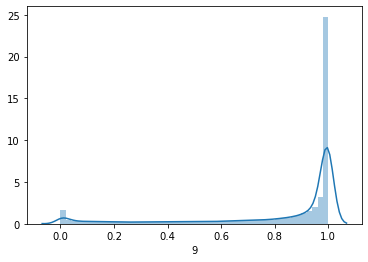

In [45]:
sns.distplot(results[9])

In [46]:
percentiles = results.apply(lambda x: np.percentile(x,q=[97.5, 2.5]))

In [47]:
percentiles

0             1         2             3         4        5  \
0  9.999999e-01  9.945098e-01  1.000000  1.000000e+00  1.000000  1.00000   
1  1.557324e-34  2.219717e-21  0.000006  2.393496e-16  0.998063  0.80821   

          6         7         8         9            10        11  \
0  1.000000  1.000000  1.000000  1.000000  9.999999e-01  1.000000   
1  0.000085  0.945016  0.985547  0.009132  5.633311e-17  0.998027   

             12        13        14            15            16            17  \
0  9.999875e-01  1.000000  1.000000  8.403187e-01  9.269452e-01  9.999606e-01   
1  8.353915e-31  0.982739  0.000072  5.388183e-24  3.263511e-21  6.483280e-29   

             18        19        20        21        22        23  \
0  9.997932e-01  1.000000  1.000000  1.000000  1.000000  1.000000   
1  6.539069e-16  0.527933  0.830544  0.686072  0.000002  0.185946   

             24            25            26            27        28        29  \
0  1.000000e+00  7.221287e-01  1.411518e-01  9.887029e-01  1.000000  1.000000   
1  6.545849e-37  7.546187e-30  2.198405e-42  4.812721e-26  0.713432  0.246487   

         30        31        32        33            34            35  \
0  1.000000  1.000000  1.000000  1.000000  9.991595e-01  9.998835e-01   
1  0.014444  0.000002  0.450787  0.006951  2.478704e-48  1.106533e-17   

             36        37            38        39            40            41  \
0  9.210297e-01  1.000000  9.993235e-01  1.000000  1.000000e+00  8.780239e-01   
1  5.105428e-36  0.989995  5.809040e-10  0.060256  4.768009e-18  8.462027e-43   

             42            43            44       45        46        47  \
0  9.999989e-01  9.999932e-01  1.000000e+00  1.00000  1.000000  1.000000   
1  1.482634e-18  1.056368e-12  2.860525e-30  0.99757  0.820403  0.944147   

             48        49            50  
0  4.799498e-01  0.999996  1.890365e-01  
1  3.742266e-54  0.000587  9.496560e-60

In [48]:
res_states = res.to_frame()

In [49]:
res_states['States'] = states

In [50]:
res_states

0  States
0   0.200706  states
1   0.106226  states
2   0.779589  states
3   0.423070  states
4   0.995144  states
5   0.982949  states
6   0.918264  states
7   0.991816  states
8   0.983208  states
9   0.816015  states
10  0.404682  states
11  0.998050  states
12  0.139847  states
13  0.994081  states
14  0.708872  states
15  0.071014  states
16  0.093879  states
17  0.148531  states
18  0.247943  states
19  0.970355  states
20  0.980578  states
21  0.976632  states
22  0.679821  states
23  0.954861  states
24  0.200014  states
25  0.040723  states
26  0.013745  states
27  0.103118  states
28  0.974330  states
29  0.951976  states
30  0.949780  states
31  0.813249  states
32  0.971237  states
33  0.846787  states
34  0.077987  states
35  0.237226  states
36  0.058742  states
37  0.996670  states
38  0.391295  states
39  0.948742  states
40  0.406842  states
41  0.044220  states
42  0.291718  states
43  0.359324  states
44  0.363769  states
45  0.998386  states
46  0.983610  states
47  0.987096  states
48  0.026892  states
49  0.731945  states
50  0.019232  states

In [27]:
traces = [trace2, trace3]
model_dict = dict(zip([election_model2, election_model3], traces))
#comp = pm.compare(model_dict, method='BB-pseudo-BMA')
#comp

In [21]:
election_model2.name = "model 2"
election_model3.name = "model 3"

In [29]:
comp = pm.compare(model_dict)

In [31]:
comp

rank      loo    p_loo    d_loo  \
<pymc3.model.Model object at 0x7f825088af40>    0 -72.2463  54.3671        0   
<pymc3.model.Model object at 0x7f82414b1520>    1 -109.334   40.034  37.0873   

                                                   weight       se      dse  \
<pymc3.model.Model object at 0x7f825088af40>            1  8.27871        0   
<pymc3.model.Model object at 0x7f82414b1520>  1.77035e-11  11.4031  6.06813   

                                             warning loo_scale  
<pymc3.model.Model object at 0x7f825088af40>    True       log  
<pymc3.model.Model object at 0x7f82414b1520>    True       log

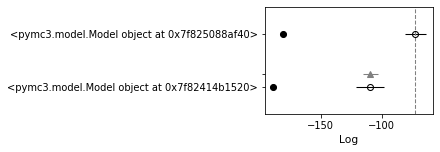

In [30]:
pm.compareplot(comp)

In [25]:
states = df.state_fips.replace(states_lookup).values

with pm.Model() as election_model3:
    
    # Priors
    mu_a = pm.Normal('mu_a', mu=0, sigma=5)
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    mu_b = pm.Normal('mu_b', mu=0, sigma=5)
    sigma_b = pm.HalfCauchy('sigma_b', 5)
    
    alpha_offset = pm.Normal('alpha_offset', mu=0, sd=1, shape=num_states)
    alpha = pm.Deterministic('alpha', mu_a + alpha_offset * sigma_a)
    
    beta_i_offset = pm.Normal('beta_i_offset', mu=0, sd=1, shape=num_states)
    beta_income = pm.Deterministic('beta_income', mu_b + beta_i_offset * sigma_b)
    beta_demmargin_offset = pm.Normal('beta_demmargin_offset', 0, 1, shape=num_states)
    beta_demmargin = pm.Deterministic('beta_demmargin', mu_b + beta_demmargin_offset * sigma_b)
    beta_urban_offset = pm.Normal('beta_urban_offset', 0, 1, shape=num_states)
    beta_urban = pm.Deterministic('beta_urban', mu_b + beta_urban_offset * sigma_b)
    beta_dens_offset = pm.Normal('beta_dens_offset', 0, 1, shape=num_states)
    beta_density = pm.Deterministic('beta_density', mu_b + sigma_b * beta_dens_offset)
    #beta_nonHS = pm.Normal('beta_nonHS', mu_b, sd=sigma_b, shape=num_states)
    #beta_pctasian = pm.Normal('beta_pctasian', mu_b, sd=sigma_b, shape=num_states)
    beta_adv_offset = pm.Normal('beta_adv_offset', 0, 1, shape=num_states)
    beta_advanced = pm.Deterministic('beta_advanced', mu_b + sigma_b * beta_adv_offset)
    beta_demshare_offset = pm.Normal('beta_demshare_offset', 0, 1, shape=num_states)
    beta_demshare = pm.Deterministic('beta_demshare', mu_b + sigma_b * beta_demshare_offset)
    beta_evan_offset = pm.Normal('beta_evan_offset', 0, 1, shape=num_states)
    beta_evan = pm.Deterministic('beta_evan', mu_b + sigma_b * beta_evan_offset)
    
   
    income = pm.Data('income', df_model.Pct_Over_National_Average.values)
    demmargin = pm.Data('demmargin', df_model.dem_margin.values)
    urban = pm.Data('urban', df_model.urban_pct.values)
    density = pm.Data('density', df_model.pop_density.values)
    #nonHS = pm.Data('nonHS', df.nonHS_graduate.values)
    #pct_asian = pm.Data('pct_asian', df.pct_asian.values)
    adv_degree = pm.Data('adv_degree', df_model.advanced_degree_or_more.values)
    dem_voteshare = pm.Data('dem_voteshare', df_model.dem_voteshare_ratechange.values)
    evang = pm.Data('evang', df_model.evangelical_pct.values)
    
    states = pm.Data('states', states)
    
    dem_win = pm.Data('dem_win', df_model.dem_state_win.values)
    
    sigma_y = pm.HalfCauchy('sigma_y',0.001)
    
    
    mu = alpha[states] + beta_income[states] * income  + beta_demmargin[states] * demmargin + beta_urban[states] * urban + beta_density[states] * density + beta_advanced[states] * adv_degree + beta_demshare[states] * dem_voteshare + beta_evan[states] * evang + sigma_y
    
    
    
    #theta = pm.Deterministic('theta', pm.invlogit(mu))
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    
    #Y_obs = pm.Binomial('Y_obs', p=theta, n=num_states, observed=df['dem_state_win'].values)
    
    Y_obs = pm.Bernoulli('Y_obs', theta, observed=dem_win)
    
#model_to_graphviz(election_model)

In [19]:
# with election_model_non_centered:
#     trace4 = pm.sample(8000, chains=4, tune=4000, target_accept=0.95)

#nuts_kwargs=dict(target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sigma_y, beta_evan_offset, beta_demshare_offset, beta_adv_offset, beta_dens_offset, beta_urban_offset, beta_demmargin_offset, beta_i_offset, alpha_offset, sigma_b, mu_b, sigma_a, mu_a]


Sampling 4 chains for 4_000 tune and 8_000 draw iterations (16_000 + 32_000 draws total) took 504 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 147 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9028491019489762, but should be close to 0.95. Try to increase the number of tuning steps.
There were 158 divergences after tuning. Increase `target_accept` or reparameterize.
There were 167 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [26]:
#pm.save_trace(trace4, 'non_centered_trace.trace', overwrite=True)
trace3 = pm.load_trace('non_centered_trace.trace', model=election_model3)

In [22]:
pm.summary(trace3)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
mu_a             0.525  0.597  -0.549    1.697      0.008    0.005    6076.0   
mu_b             1.096  0.226   0.688    1.511      0.004    0.003    3816.0   
alpha_offset[0] -0.994  0.738  -2.415    0.411      0.008    0.006    8893.0   
alpha_offset[1] -1.006  0.672  -2.270    0.240      0.006    0.004   13959.0   
alpha_offset[2] -0.586  0.515  -1.588    0.364      0.005    0.004   10181.0   
...                ...    ...     ...      ...        ...      ...       ...   
theta[352]       0.726  0.204   0.352    1.000      0.002    0.002    8473.0   
theta[353]       0.983  0.040   0.929    1.000      0.000    0.000   26491.0   
theta[354]       0.032  0.057   0.000    0.121      0.000    0.000   17851.0   
theta[355]       0.783  0.185   0.426    1.000      0.002    0.001    8387.0   
theta[356]       0.012  0.035   0.000    0.048      0.000    0.000   27495.0   

                  ess_sd  ess_bulk  ess_tail  r_hat  
mu_a              6076.0    6157.0    9745.0    1.0  
mu_b              2747.0    5596.0    3913.0    1.0  
alpha_offset[0]   8893.0    9044.0    6918.0    1.0  
alpha_offset[1]  13959.0   13571.0   11757.0    1.0  
alpha_offset[2]  10002.0   10517.0    8186.0    1.0  
...                  ...       ...       ...    ...  
theta[352]        6885.0    5575.0    5081.0    1.0  
theta[353]       26472.0   13073.0    8658.0    1.0  
theta[354]       17851.0    4106.0    4315.0    1.0  
theta[355]        8387.0   11088.0    9398.0    1.0  
theta[356]       24797.0   10076.0    6441.0    1.0  

[1178 rows x 11 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f75f44ea610>,
      dtype=object)

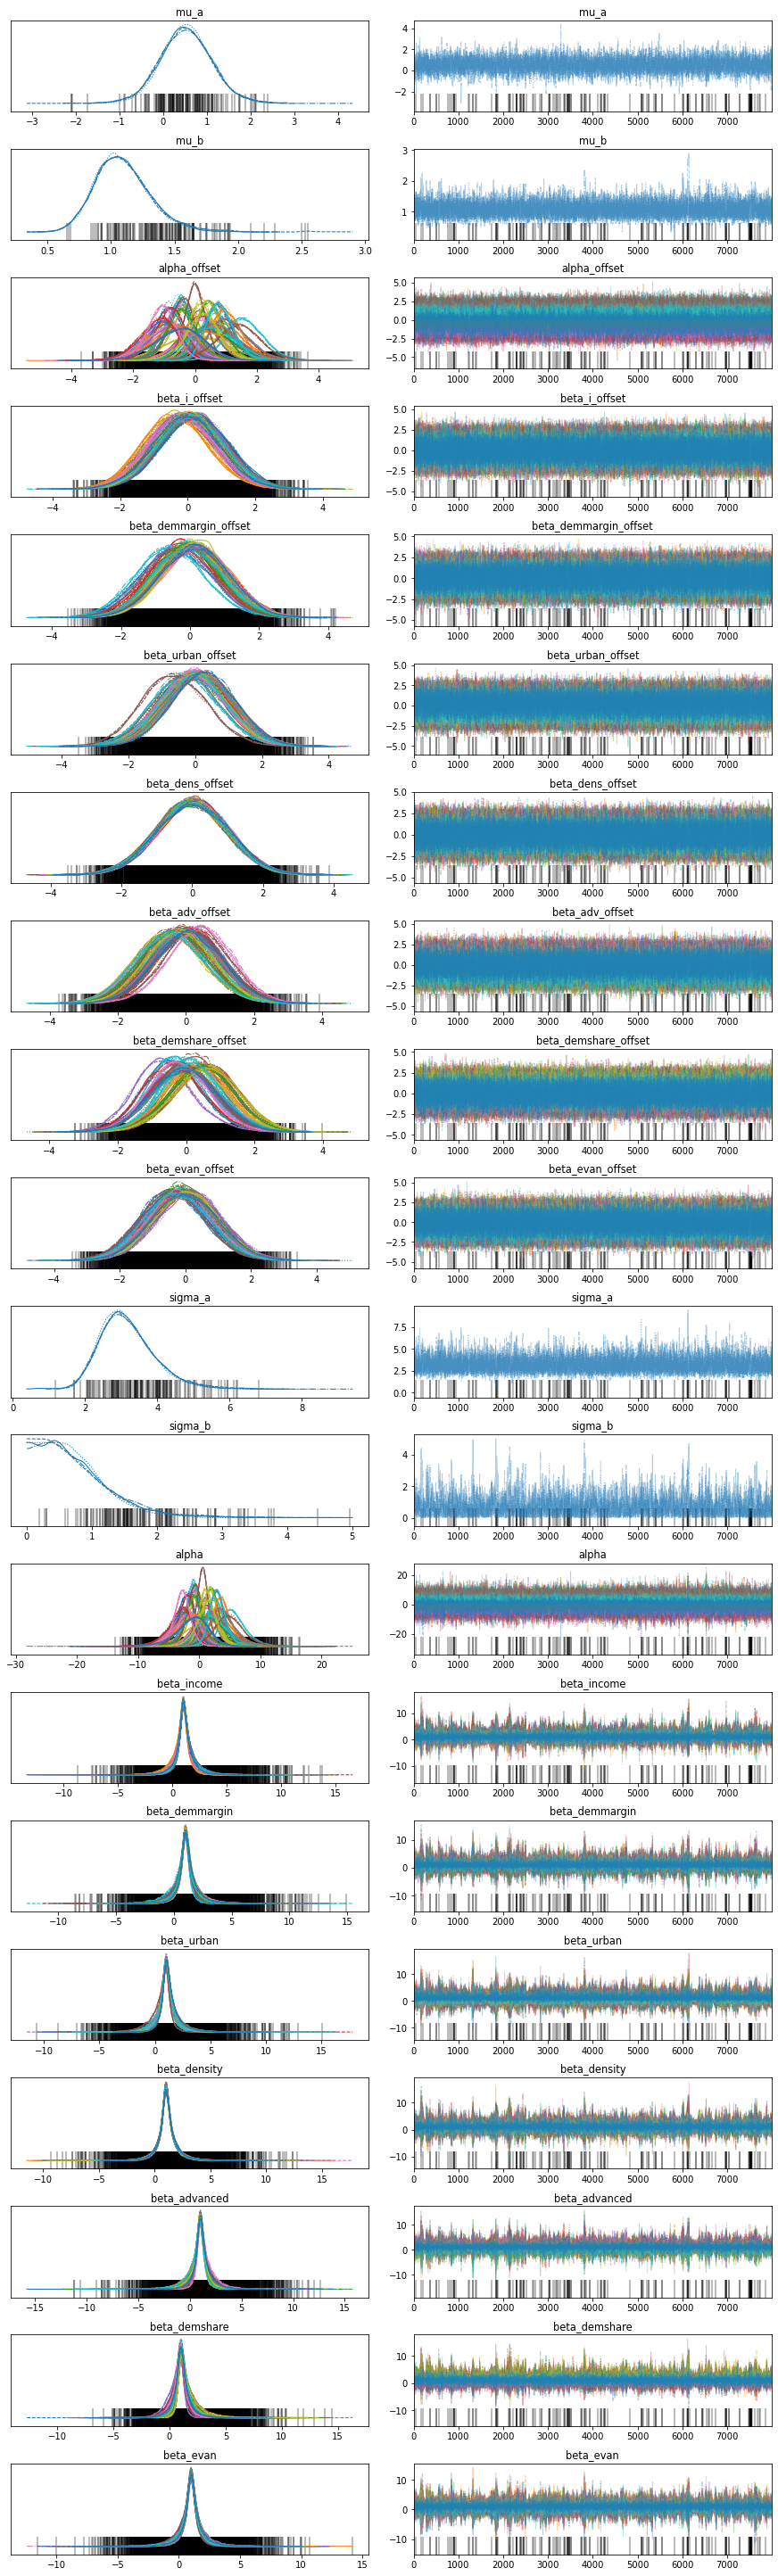

In [26]:
pm.traceplot(trace3)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f92052e77f0>],
      dtype=object)

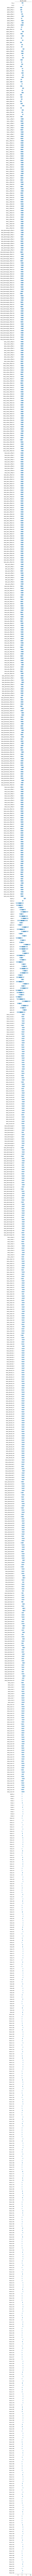

In [35]:
pm.forestplot(trace3)

In [53]:
# with election_model3:
#     pm.set_data({'states': states50, 'income': df20.Pct_Over_National_Average.values, 
#                'urban': df20.urban_pct.values, 'demmargin': df20.dem_margin.values,
#                'density': df20.pop_density.values, 'adv_degree': df20.advanced_degree_or_more.values,
#                'evang': df20.evangelical_pct.values, 'dem_voteshare': df20.dem_voteshare_ratechange.values})
#                 #'dem_win': np.empty_like(df20.evangelical_pct.values)})
#     y_test_non_centered = pm.sample_posterior_predictive(trace3, var_names = ['theta'])

In [47]:
results_n_centered = pd.DataFrame.from_records(y_test_non_centered['theta'])

results_n_centered

0         1         2         3         4         5         6  \
0      0.287112  0.062157  0.288907  0.177483  0.999970  0.894008  0.997263   
1      0.020822  0.028034  0.721706  0.227401  0.999692  0.868663  0.997989   
2      0.159937  0.059405  0.143196  0.146317  0.999779  0.782039  0.981806   
3      0.703008  0.000517  0.084217  0.296656  0.999982  0.605527  0.999536   
4      0.007129  0.019291  0.235449  0.902434  0.999999  0.870881  0.998589   
...         ...       ...       ...       ...       ...       ...       ...   
31995  0.260299  0.041510  0.790708  0.227545  0.998365  0.625912  0.999983   
31996  0.550114  0.051404  0.678210  0.110591  0.999286  0.809996  0.999884   
31997  0.872551  0.097891  0.738741  0.405912  0.999566  0.608683  0.999906   
31998  0.685224  0.075551  0.230106  0.134308  0.999942  0.739434  0.999913   
31999  0.008457  0.000431  0.983582  0.983699  0.995980  0.985412  0.997215   

              7         8         9        10        11        12        13  \
0      0.991348  0.999835  0.142181  0.138197  0.960479  0.000912  0.999319   
1      0.988831  1.000000  0.634827  0.347015  0.996290  0.001349  0.903340   
2      0.997330  1.000000  0.569750  0.225855  0.975224  0.123437  0.999974   
3      0.995629  1.000000  0.134874  0.478909  0.991222  0.057506  0.999882   
4      0.999657  1.000000  0.990061  0.872054  0.977921  0.006514  0.999997   
...         ...       ...       ...       ...       ...       ...       ...   
31995  0.996338  1.000000  0.577829  0.278808  0.935854  0.338192  0.997407   
31996  0.998977  1.000000  0.612826  0.696016  0.949229  0.428874  0.997724   
31997  0.998400  1.000000  0.379776  0.837867  0.993149  0.033080  0.995084   
31998  0.994688  1.000000  0.506745  0.516795  0.961649  0.025957  0.999224   
31999  0.999202  1.000000  0.884050  0.045119  0.999857  0.011407  0.998273   

             14        15        16        17        18        19        20  \
0      0.195919  0.250408  0.010646  0.970098  0.079901  0.993941  0.996848   
1      0.299979  0.122635  0.002077  0.118242  0.077947  0.813575  0.999993   
2      0.090966  0.293496  0.137042  0.079021  0.224516  0.999516  0.999046   
3      0.280978  0.674582  0.005703  0.042086  0.581572  0.998138  0.999998   
4      0.006698  0.179458  0.000636  0.740792  0.505494  0.884115  0.999954   
...         ...       ...       ...       ...       ...       ...       ...   
31995  0.244599  0.316843  0.235491  0.151137  0.408038  0.609244  0.999976   
31996  0.274976  0.133243  0.336336  0.073143  0.206476  0.598572  0.999230   
31997  0.220103  0.354091  0.088206  0.676675  0.528068  0.902830  0.996501   
31998  0.137367  0.168036  0.289631  0.358854  0.373270  0.995663  0.999991   
31999  0.698164  0.515100  0.000230  0.004455  0.195535  0.848653  0.999615   

             21        22        23        24        25        26        27  \
0      0.943222  0.782321  0.995928  0.000175  0.089933  0.006220  0.001122   
1      0.982634  0.435916  0.942300  0.103781  0.008902  0.027633  0.001660   
2      0.999986  0.940998  0.998433  0.036033  0.080749  0.009369  0.137465   
3      0.999908  0.839746  0.989446  0.111181  0.193737  0.001136  0.196986   
4      0.999999  0.809752  0.988138  0.015014  0.020083  0.098624  0.000132   
...         ...       ...       ...       ...       ...       ...       ...   
31995  0.999280  0.765858  0.870615  0.000930  0.184977  0.298854  0.027002   
31996  0.997621  0.822261  0.896510  0.000845  0.220912  0.130690  0.074769   
31997  0.913135  0.952972  0.940142  0.001291  0.246903  0.213144  0.062265   
31998  0.986330  0.662209  0.993657  0.000008  0.252144  0.024628  0.000843   
31999  1.000000  0.991187  0.535026  0.004286  0.001092  0.025260  0.001293   

             28        29        30        31        32        33  \
0      0.780816  0.694908  0.981122  0.941296  0.999849  0.092594   
1      0.737486  0.868753  0.974289  0.988165  0.951194  0.930325   
2      0.67

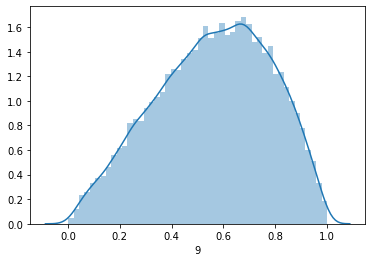

In [48]:
res_n_centered_ev = results_n_centered.apply('mean')

sns.distplot(results_n_centered[9])

In [40]:
percentiles_n_centered = results_n_centered.apply(lambda x: np.percentile(x,q=[97.5, 2.5]))

percentiles_n_centered

0         1         2         3         4         5         6  \
0  0.740307  0.289582  0.963741  0.946867  1.000000  0.995335  0.999999   
1  0.000034  0.000040  0.040387  0.007788  0.929994  0.309833  0.309826   

          7         8         9        10        11        12        13  \
0  0.999995  1.000000  0.930765  0.940176  0.999993  0.516938  0.999996   
1  0.754174  0.997637  0.117264  0.015216  0.732879  0.000009  0.859480   

         14        15        16        17        18        19        20  \
0  0.828554  0.876274  0.463367  0.820297  0.823986  0.999923  1.000000   
1  0.005799  0.002393  0.000082  0.000525  0.007110  0.523588  0.859635   

         21        22        23        24        25        26        27  \
0  1.000000  0.989498  0.999932  0.814445  0.528971  0.445288  0.328128   
1  0.848514  0.150351  0.567935  0.000011  0.000124  0.000027  0.000012   

         28        29        30        31        32        33            34  \
0  0.977104  0.998112  0.999999  0.999243  0.999999  0.955361  1.071894e-01   
1  0.297610  0.234971  0.609960  0.522605  0.626240  0.026021  5.129364e-08   

         35        36        37        38        39        40            41  \
0  0.872534  0.325241  0.999993  0.989068  0.999994  0.879019  1.069731e-01   
1  0.007916  0.000006  0.898743  0.114176  0.513545  0.000297  2.706971e-07   

         42        43        44        45        46        47        48  \
0  0.857976  0.715315  0.983681  0.999999  0.998016  0.999997  0.621745   
1  0.006699  0.000615  0.000119  0.827485  0.251277  0.832907  0.000002   

         49            50  
0  0.987251  5.172907e-02  
1  0.221537  1.370342e-08

In [49]:
res_n_centered_ev = res_n_centered_ev.to_frame()

states = df['state'][:51].tolist()

res_n_centered_ev['States'] = states

res_n_centered_ev

0                States
0   0.132004               Alabama
1   0.045290                Alaska
2   0.547332               Arizona
3   0.384866              Arkansas
4   0.990503            California
5   0.774968              Colorado
6   0.917810           Connecticut
7   0.966054              Delaware
8   0.995658  District of Columbia
9   0.560039               Florida
10  0.492345               Georgia
11  0.960234                Hawaii
12  0.069053                 Idaho
13  0.980379              Illinois
14  0.216948               Indiana
15  0.353973                  Iowa
16  0.086332                Kansas
17  0.245197              Kentucky
18  0.328408             Louisiana
19  0.920177                 Maine
20  0.983556              Maryland
21  0.982387         Massachusetts
22  0.744675              Michigan
23  0.929820             Minnesota
24  0.137180           Mississippi
25  0.120385              Missouri
26  0.078741               Montana
27  0.046977              Nebraska
28  0.755576                Nevada
29  0.770473         New Hampshire
30  0.956706            New Jersey
31  0.929874            New Mexico
32  0.955163              New York
33  0.420460        North Carolina
34  0.012255          North Dakota
35  0.377369                  Ohio
36  0.045802              Oklahoma
37  0.984985                Oregon
38  0.726191          Pennsylvania
39  0.929641          Rhode Island
40  0.196433        South Carolina
41  0.013021          South Dakota
42  0.319544             Tennessee
43  0.185565                 Texas
44  0.378777                  Utah
45  0.975481               Vermont
46  0.745461              Virginia
47  0.977382            Washington
48  0.099676         West Virginia
49  0.756583             Wisconsin
50  0.006694               Wyoming

In [50]:
res_n_centered_ev.to_csv('data/fundamentals_probs.csv', index=False)

### Try Results Simulation

In [27]:
with election_model3:
    pm.set_data({'states': states50, 'income': df20.Pct_Over_National_Average.values, 
               'urban': df20.urban_pct.values, 'demmargin': df20.dem_margin.values,
               'density': df20.pop_density.values, 'adv_degree': df20.advanced_degree_or_more.values,
               'evang': df20.evangelical_pct.values, 'dem_voteshare': df20.dem_voteshare_ratechange.values})
                #'dem_win': np.empty_like(df20.evangelical_pct.values)})
    y_test3 = pm.sample_posterior_predictive(trace3)

In [33]:
simuls = pd.DataFrame.from_records(y_test3['Y_obs'])

In [36]:
simuls.columns = states

In [39]:
simuls.to_csv('data/simuls.csv', index=None)

In [61]:

states = df.state_fips.replace(states_lookup).values

with pm.Model() as election_model4:
    
    # Priors
    mu_a = pm.Normal('mu_a', mu=0, sigma=5)
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    mu_b = pm.Normal('mu_b', mu=0, sigma=5)
    sigma_b = pm.HalfCauchy('sigma_b', 5)
    
    alpha_offset = pm.Normal('alpha_offset', mu=0, sd=1, shape=num_states)
    alpha = pm.Deterministic('alpha', mu_a + alpha_offset * sigma_a)
    
    beta_i_offset = pm.Normal('beta_i_offset', mu=0, sd=1, shape=num_states)
    beta_income = pm.Deterministic('beta_income', mu_b + beta_i_offset * sigma_b)
    beta_demmargin_offset = pm.Normal('beta_demmargin_offset', 0, 1, shape=num_states)
    beta_demmargin = pm.Deterministic('beta_demmargin', mu_b + beta_demmargin_offset * sigma_b)
    beta_urban_offset = pm.Normal('beta_urban_offset', 0, 1, shape=num_states)
    beta_urban = pm.Deterministic('beta_urban', mu_b + beta_urban_offset * sigma_b)
    #beta_dens_offset = pm.Normal('beta_dens_offset', 0, 1, shape=num_states)
    #beta_density = pm.Deterministic('beta_density', mu_b + sigma_b * beta_dens_offset)
    beta_nonHS_offset = pm.Normal('beta_nonHS_offset', 0, 1, shape=num_states)
    beta_nonHS = pm.Deterministic('beta_nonHS', mu_b + beta_nonHS_offset * sigma_b)
    #beta_pctasian = pm.Normal('beta_pctasian', mu_b, sd=sigma_b, shape=num_states)
    #beta_adv_offset = pm.Normal('beta_adv_offset', 0, 1, shape=num_states)
    #beta_advanced = pm.Deterministic('beta_advanced', mu_b + sigma_b * beta_adv_offset)
    beta_demshare_offset = pm.Normal('beta_demshare_offset', 0, 1, shape=num_states)
    beta_demshare = pm.Deterministic('beta_demshare', mu_b + sigma_b * beta_demshare_offset)
    beta_evan_offset = pm.Normal('beta_evan_offset', 0, 1, shape=num_states)
    beta_evan = pm.Deterministic('beta_evan', mu_b + sigma_b * beta_evan_offset)
    
   
    income = pm.Data('income', df_model.Pct_Over_National_Average.values)
    demmargin = pm.Data('demmargin', df_model.dem_margin.values)
    urban = pm.Data('urban', df_model.urban_pct.values)
    #density = pm.Data('density', df_model.pop_density.values)
    nonHS = pm.Data('nonHS', df_model.nonHS_graduate.values)
    #pct_asian = pm.Data('pct_asian', df.pct_asian.values)
    #adv_degree = pm.Data('adv_degree', df_model.advanced_degree_or_more.values)
    dem_voteshare = pm.Data('dem_voteshare', df_model.dem_voteshare_ratechange.values)
    evang = pm.Data('evang', df_model.evangelical_pct.values)
    
    states = pm.Data('states', states)
    
    dem_win = pm.Data('dem_win', df_model.dem_state_win.values)
    
    sigma_y = pm.HalfCauchy('sigma_y',0.001)
    
    
    mu = alpha[states] + beta_income[states] * income  + beta_demmargin[states] * demmargin + beta_urban[states] * urban + beta_nonHS[states] * nonHS + beta_demshare[states] * dem_voteshare + beta_evan[states] * evang + sigma_y
    
    
    
    #theta = pm.Deterministic('theta', pm.invlogit(mu))
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    
    #Y_obs = pm.Binomial('Y_obs', p=theta, n=num_states, observed=df['dem_state_win'].values)
    
    Y_obs = pm.Bernoulli('Y_obs', theta, observed=dem_win)
    
#model_to_graphviz(election_model)

In [ ]:
# with election_model4:
#      trace4 = pm.sample(8000, chains=4, tune=2000, target_accept=0.95)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sigma_y, beta_evan_offset, beta_demshare_offset, beta_nonHS_offset, beta_urban_offset, beta_demmargin_offset, beta_i_offset, alpha_offset, sigma_b, mu_b, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 8_000 draw iterations (8_000 + 32_000 draws total) took 583 seconds.


In [62]:
#pm.save_trace(trace4, 'models/trace4.trace', overwrite=True)
trace4 = pm.load_trace('models/trace4.trace', election_model4)

In [38]:
states50 = np.arange(51, step=1, dtype='int32')

In [39]:

with election_model4:
    pm.set_data({'states': states50, 'income': df20.Pct_Over_National_Average.values, 
               'urban': df20.urban_pct.values, 'nonHS': df20.nonHS_graduate.values,
               'evang': df20.evangelical_pct.values, 'demmargin': df20.dem_margin.values, 
                 'dem_voteshare': df20.dem_voteshare_ratechange.values})
                #'dem_win': np.empty_like(df20.evangelical_pct.values)})
    y_test4 = pm.sample_posterior_predictive(trace4, var_names = ['theta'])
    

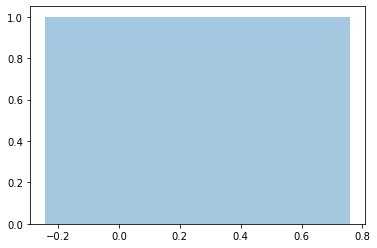

In [41]:
results4 = pd.DataFrame.from_records(y_test4['theta'])

res_4 = results4.apply('mean')

sns.distplot(res_4[9])

In [42]:
res_4 = res_4.to_frame()

states = df['state'][:51].tolist()

res_4['States'] = states

res_4

0                States
0   0.030827               Alabama
1   0.018418                Alaska
2   0.347079               Arizona
3   0.107561              Arkansas
4   0.986550            California
5   0.372204              Colorado
6   0.796800           Connecticut
7   0.918367              Delaware
8   0.766568  District of Columbia
9   0.258447               Florida
10  0.115272               Georgia
11  0.915313                Hawaii
12  0.019533                 Idaho
13  0.951231              Illinois
14  0.110300               Indiana
15  0.183563                  Iowa
16  0.014226                Kansas
17  0.041627              Kentucky
18  0.135627             Louisiana
19  0.829932                 Maine
20  0.917761              Maryland
21  0.891057         Massachusetts
22  0.689447              Michigan
23  0.855982             Minnesota
24  0.087249           Mississippi
25  0.038740              Missouri
26  0.015644               Montana
27  0.011638              Nebraska
28  0.639510                Nevada
29  0.508976         New Hampshire
30  0.839864            New Jersey
31  0.819760            New Mexico
32  0.909467              New York
33  0.118177        North Carolina
34  0.008157          North Dakota
35  0.208094                  Ohio
36  0.013794              Oklahoma
37  0.955769                Oregon
38  0.703381          Pennsylvania
39  0.857908          Rhode Island
40  0.031298        South Carolina
41  0.005777          South Dakota
42  0.070791             Tennessee
43  0.035723                 Texas
44  0.189275                  Utah
45  0.812693               Vermont
46  0.221569              Virginia
47  0.928730            Washington
48  0.048942         West Virginia
49  0.661181             Wisconsin
50  0.003326               Wyoming

In [64]:
traces = [trace2, trace3, trace4]
model_dict = dict(zip([election_model2, election_model3, election_model4], traces))
comp = pm.compare(model_dict, method='BB-pseudo-BMA')
comp

ValueError: Input dimension mis-match. (input[0].shape[0] = 357, input[3].shape[0] = 51)
Apply node that caused the error: Elemwise{Composite{Switch(Cast{int8}((GE(Cast{int64}(i0), i1) * LE(Cast{int64}(i0), i2) * GE(scalar_sigmoid(Composite{(i0 + (i1 * i2) + (i3 * i4) + (i5 * i6) + (i7 * i8) + (i9 * i10) + (i11 * i12) + (i13 * i14) + (i15 * i16) + (i17 * i18) + i19)}(i3, i4, i5, i6, i7, i8, i9, i10, i11, i12, i13, i14, i15, i16, i17, i18, i19, i20, i21, i22)), i1) * LE(scalar_sigmoid(Composite{(i0 + (i1 * i2) + (i3 * i4) + (i5 * i6) + (i7 * i8) + (i9 * i10) + (i11 * i12) + (i13 * i14) + (i15 * i16) + (i17 * i18) + i19)}(i3, i4, i5, i6, i7, i8, i9, i10, i11, i12, i13, i14, i15, i16, i17, i18, i19, i20, i21, i22)), i2))), Switch(Cast{int64}(i0), (-scalar_softplus((-Composite{(i0 + (i1 * i2) + (i3 * i4) + (i5 * i6) + (i7 * i8) + (i9 * i10) + (i11 * i12) + (i13 * i14) + (i15 * i16) + (i17 * i18) + i19)}(i3, i4, i5, i6, i7, i8, i9, i10, i11, i12, i13, i14, i15, i16, i17, i18, i19, i20, i21, i22)))), (-scalar_softplus(Composite{(i0 + (i1 * i2) + (i3 * i4) + (i5 * i6) + (i7 * i8) + (i9 * i10) + (i11 * i12) + (i13 * i14) + (i15 * i16) + (i17 * i18) + i19)}(i3, i4, i5, i6, i7, i8, i9, i10, i11, i12, i13, i14, i15, i16, i17, i18, i19, i20, i21, i22)))), i23)}}[(0, 3)](dem_win, TensorConstant{(1,) of 0}, TensorConstant{(1,) of 1}, AdvancedSubtensor1.0, AdvancedSubtensor1.0, income, AdvancedSubtensor1.0, demmargin, AdvancedSubtensor1.0, urban, AdvancedSubtensor1.0, density, AdvancedSubtensor1.0, pct_asian, AdvancedSubtensor1.0, adv_degree, AdvancedSubtensor1.0, dem_voteshare, AdvancedSubtensor1.0, evang, Elemwise{Composite{(i0 + (i1 * i2))}}[(0, 1)].0, consumer, Elemwise{exp,no_inplace}.0, TensorConstant{(1,) of -inf})
Toposort index: 28
Inputs types: [TensorType(int32, vector), TensorType(int8, (True,)), TensorType(int8, (True,)), TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, (True,)), TensorType(float64, vector), TensorType(float64, (True,)), TensorType(float32, (True,))]
Inputs shapes: [(357,), (1,), (1,), (51,), (51,), (51,), (51,), (51,), (51,), (51,), (51,), (51,), (51,), (51,), (51,), (51,), (51,), (51,), (51,), (51,), (1,), (51,), (1,), (1,)]
Inputs strides: [(4,), (1,), (1,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (4,)]
Inputs values: ['not shown', array([0], dtype=int8), array([1], dtype=int8), 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', array([-2.42660716]), 'not shown', array([0.00121499]), array([-inf], dtype=float32)]
Outputs clients: [['output']]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [ ]:
states = df.state_fips.replace(states_lookup).values

with pm.Model() as election_model5:
    
    # Priors
    mu_a = pm.Normal('mu_a', mu=0, sigma=5)
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    mu_b = pm.Normal('mu_b', mu=0, sigma=5)
    sigma_b = pm.HalfCauchy('sigma_b', 5)
    
    alpha_offset = pm.Normal('alpha_offset', mu=0, sd=1, shape=num_states)
    alpha = pm.Deterministic('alpha', mu_a + alpha_offset * sigma_a)
    
    beta_i_offset = pm.Normal('beta_i_offset', mu=0, sd=1, shape=num_states)
    beta_income = pm.Deterministic('beta_income', mu_b + beta_i_offset * sigma_b)
    beta_demmargin_offset = pm.Normal('beta_demmargin_offset', 0, 1, shape=num_states)
    beta_demmargin = pm.Deterministic('beta_demmargin', mu_b + beta_demmargin_offset * sigma_b)
    beta_urban_offset = pm.Normal('beta_urban_offset', 0, 1, shape=num_states)
    beta_urban = pm.Deterministic('beta_urban', mu_b + beta_urban_offset * sigma_b)
    beta_dens_offset = pm.Normal('beta_dens_offset', 0, 1, shape=num_states)
    beta_density = pm.Deterministic('beta_density', mu_b + sigma_b * beta_dens_offset)
    beta_nonHS_offset = pm.Normal('beta_nonHS_offset', 0, 1, shape=num_states)
    beta_nonHS = pm.Deterministic('beta_nonHS', mu_b + sigma_b * beta_nonHS_offset)
    beta_pctasian_offset = pm.Normal('beta_pctasian_offset', 0, 1, shape=num_states)
    beta_pctasian = pm.Deterministic('beta_pctasian', mu_b + sigma_b * beta_pctasian_offset)
    beta_adv_offset = pm.Normal('beta_adv_offset', 0, 1, shape=num_states)
    beta_advanced = pm.Deterministic('beta_advanced', mu_b + sigma_b * beta_adv_offset)
    beta_demshare_offset = pm.Normal('beta_demshare_offset', 0, 1, shape=num_states)
    beta_demshare = pm.Deterministic('beta_demshare', mu_b + sigma_b * beta_demshare_offset)
    beta_evan_offset = pm.Normal('beta_evan_offset', 0, 1, shape=num_states)
    beta_evan = pm.Deterministic('beta_evan', mu_b + sigma_b * beta_evan_offset)
#     beta_consumer_offset = pm.Normal('beta_consumer_offset', 0, 1)
#     beta_consumer = pm.Deterministic('beta_consumer', mu_b + sigma_b * beta_consumer_offset)
    beta_approval_offset = pm.Normal('beta_approval_offset', 0, 1)
    beta_approval = pm.Deterministic('beta_approval', mu_b + sigma_b * beta_approval_offset)
   
    income = pm.Data('income', df_model.Pct_Over_National_Average.values)
    demmargin = pm.Data('demmargin', df_model.dem_margin.values)
    urban = pm.Data('urban', df_model.urban_pct.values)
    density = pm.Data('density', df_model.pop_density.values)
    nonHS = pm.Data('nonHS', df_model.nonHS_graduate.values)
    pct_asian = pm.Data('pct_asian', df_model.pct_asian.values)
    adv_degree = pm.Data('adv_degree', df_model.advanced_degree_or_more.values)
    dem_voteshare = pm.Data('dem_voteshare', df_model.dem_voteshare_ratechange.values)
    evang = pm.Data('evang', df_model.evangelical_pct.values)
    #consumer = pm.Data('consumer', df_model.Idx_Consumer_Sentiment.values)
    approval = pm.Data('approval', df_model.Y4_avg_net_approval.values)
    
    states = pm.Data('states', states)
    
    dem_win = pm.Data('dem_win', df_model.dem_state_win.values)
    
    sigma_y = pm.HalfCauchy('sigma_y',0.001)
    
    
    mu = alpha[states] + beta_income[states] * income  + beta_demmargin[states] * demmargin + beta_urban[states] * urban + beta_density[states] * density + beta_nonHS[states] * nonHS + beta_advanced[states] * adv_degree + beta_demshare[states] * dem_voteshare + beta_evan[states] * evang + beta_approval * approval + sigma_y
    
    
    
    #theta = pm.Deterministic('theta', pm.invlogit(mu))
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    
    #Y_obs = pm.Binomial('Y_obs', p=theta, n=num_states, observed=df['dem_state_win'].values)
    
    Y_obs = pm.Bernoulli('Y_obs', theta, observed=dem_win)